### P3.2 Symulacja ruchu ciężarków zawieszonych na sprężynach

- Wyprowadzić model ruchu dwóch (trzech) ciężarków zawieszonych na sprężynach. 
- Zasymulować ruch za pomocą metody Eulera. 
- Wygenerować 20 sekundową animację (zapisać w pliku MP4).

#### Model ruchu ciężarków zawieszonych na sprężynach

$ N $ - liczba ciężarków

$ x_i(t) $ - pozycja $i$-tego ciężarka w chwili $t$ ($i=1,...,N$)

$ L_i $ - długość $i$-tej sprężyny w równowadze ($i=0,...,N-1$)

$ k $ - współczynnik sprężystości sprężyn

$ m $ - masa każdego z ciężarków

Niech $ x_0(t) = 0 $ dla dowolnego $t$ (punkt zaczepienia o ścianę)

Wtedy:

$ m_j \cdot x_j'' = - k \cdot (x_j - x_{j-1} - L_{j-1}) + k \cdot (x_{j+1} - x_j - L_j) $

Niech:

$y_{i,0} = x_i$

$y_{i,1} = x_i'$

wtedy

$y_{i,0}' = y_{i,1}$

$y_{i,1}' = - \frac{k}{m} \cdot (x_j - x_{j-1} - L_{j-1}) + \frac{k}{m} \cdot (x_{j+1} - x_j - L_j)$.

oraz

$\vec{y_i}' = \vec{f_i}(t_i, \vec{y_i}) $.

Metoda Eulera dla wektorów:

$\vec{y}[n+1] = \vec{y}[n] + h \cdot \vec{f}(t[n], \vec{y}[n]) $

In [1]:
%matplotlib inline
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def euler2(equation, symbols, y0, yp0, rng, h):
    y2_sym, y1_sym, y0_sym, t_sym = symbols
    t0, tn = rng
    
    f = sp.solve(equation, y2_sym)[0]
    
    t = np.arange(t0,tn,h)
    y, yp = np.zeros_like(t), np.zeros_like(t)
    y[0], yp[0] = y0, yp0
    
    for k in range(1, len(t)):
        yp[k] =  yp[k-1] + h * f.subs([(t_sym, t[k-1]), (y0_sym, y[k-1]), (y1_sym, yp[k-1])])
        y[k] =  y[k-1] + h * yp[k-1]
    return t, y, yp

### Przykład dla 1 ciężarka

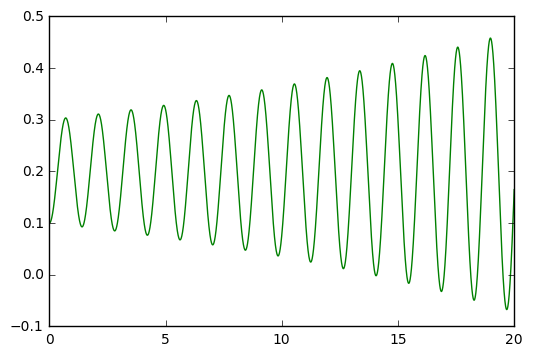

In [2]:
k = 10
L = 0.2
m = 0.5
x0 = 0.1
xp0 = 0
rng = (0,20)
h = 0.005

symbols = sp.symbols('y2 y1 y0 t')
y2, y1, y0, t = symbols
equation = sp.Eq(y2, -(k/m) * (y0 - L))

t, x, xp = euler2(equation, symbols, x0, xp0, rng, h)

plt.plot(t, x, 'g')
plt.show()

#### Wniosek: rozwiązanie rozbiega się nawet dla małych $h$

### Propozycja poprawki (wzór hybrydowy)

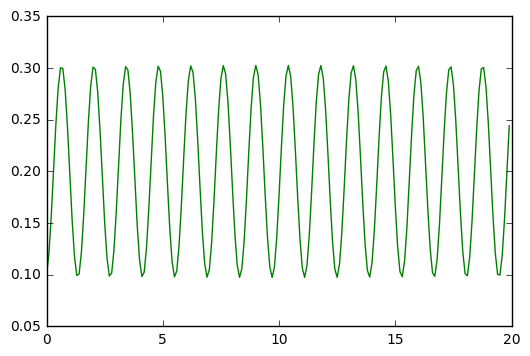

In [3]:
def euler2_hybrid(equation, symbols, y0, yp0, rng, h):
    y2_sym, y1_sym, y0_sym, t_sym = symbols
    t0, tn = rng
    
    f = sp.solve(equation, y2_sym)[0]
    
    t = np.arange(t0,tn,h)
    y, yp = np.zeros_like(t), np.zeros_like(t)
    y[0], yp[0] = y0, yp0
    
    for k in range(1, len(t)):
        yp[k] =  yp[k-1] + h * f.subs([(t_sym, t[k-1]), (y0_sym, y[k-1]), (y1_sym, yp[k-1])])
        y[k] =  y[k-1] + h * yp[k]
    return t, y, yp

k = 10
L = 0.2
m = 0.5
x0 = 0.1
xp0 = 0
rng = (0,20)
h = 0.1

symbols = sp.symbols('y2 y1 y0 t')
y2, y1, y0, t = symbols
equation = sp.Eq(y2, -(k/m) * (y0 - L))

t, x, xp = euler2_hybrid(equation, symbols, x0, xp0, rng, h)

plt.plot(t, x, 'g')
plt.show()

#### Wnioski: dużo lepszy wynik nawet dla dużo większego $h$

### Przykład dla N ciężarków (wzór standardowy + wersja hybrydowa)

In [4]:
def euler2_vec(N, equations, symbols, y0, yp0, rng, h):
    t0, tn = rng
    
    f = []
    for i in range(N):
        y2_sym, y1_sym, y0_sym, t_sym = symbols[i]
        f.append(sp.solve(equations[i], y2_sym)[0])
    
    t = np.arange(t0,tn,h)
    y, yp = np.zeros((N, len(t)), np.float64), np.zeros((N, len(t)), np.float64)
    y[..., 0], yp[..., 0] = y0, yp0
    
    for k in range(1, len(t)):
        for i in range(N):
            fi = f[i]
            for j in range(N):
                yj2, yj1, yj0, ts = symbols[j]
                fi = fi.subs([(ts, t[k-1]), (yj0, y[j,k-1]), (yj1, yp[j,k-1])])
            yp[i,k] =  yp[i,k-1] + h * fi
            y[i,k] =  y[i,k-1] + h * yp[i,k-1]
    return t, y, yp

def euler2_hybrid_vec(N, equations, symbols, y0, yp0, rng, h):
    t0, tn = rng
    
    f = []
    for i in range(N):
        y2_sym, y1_sym, y0_sym, t_sym = symbols[i]
        f.append(sp.solve(equations[i], y2_sym)[0])
    
    t = np.arange(t0,tn,h)
    y, yp = np.zeros((N, len(t)), np.float64), np.zeros((N, len(t)), np.float64)
    y[..., 0], yp[..., 0] = y0, yp0
    
    for k in range(1, len(t)):
        for i in range(N):
            fi = f[i]
            for j in range(N):
                yj2, yj1, yj0, ts = symbols[j]
                fi = fi.subs([(ts, t[k-1]), (yj0, y[j,k-1]), (yj1, yp[j,k-1])])
            yp[i,k] =  yp[i,k-1] + h * fi
            y[i,k] =  y[i,k-1] + h * yp[i,k]
    return t, y, yp

In [5]:
N = 3
k = np.array([10, 10, 10])
L = np.array([0.3, 0.3, 0.4])
m = np.array([1., 5., 5.])
x0 = np.array([0.3, 0.8, 1])
xp0 = np.array([0, 0, 0])
rng = (0,20)
h = 1/60.

symbols = [sp.symbols("ddy[%d] dy[%d] y[%d] t" % (i,i,i)) for i in range(N)]
y0_2, y0_1, y0_0, t0 = symbols[0]
y1_2, y1_1, y1_0, t1 = symbols[1]
equations = [
    sp.Eq(y0_2, -(k[0]/m[0]) * (y0_0 - L[0]) +(k[1]/m[0]) * (y1_0 - y0_0 - L[1]))
]
for i in range(1,N-1):
    y0_2, y0_1, y0_0, t0 = symbols[i-1]
    y1_2, y1_1, y1_0, t1 = symbols[i]
    y2_2, y2_1, y2_0, t2 = symbols[i+1]
    equations.append(
        sp.Eq(y1_2, -(k[i]/m[i]) * (y1_0 - y0_0 - L[i]) +(k[i+1]/m[i]) * (y2_0 - y1_0 - L[i+1]))
    )
yp_2, yp_1, yp_0, t0 = symbols[N-2]
yN_2, yN_1, yN_0, t1 = symbols[N-1]
equations.append(sp.Eq(yN_2, -(k[N-1]/m[N-1]) * (yN_0 - yp_0 - L[N-1])))

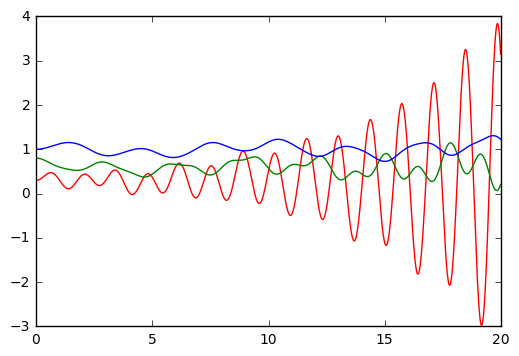

In [6]:
t, x, xp = euler2_vec(N, equations, symbols, x0, xp0, rng, h)

plt.plot(t, x[0], 'r')
plt.plot(t, x[1], 'g')
plt.plot(t, x[2], 'b')
plt.show()

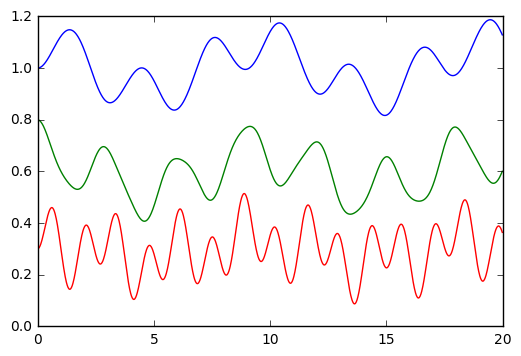

In [7]:
t, x, xp = euler2_hybrid_vec(N, equations, symbols, x0, xp0, rng, h)

plt.plot(t, x[0], 'r')
plt.plot(t, x[1], 'g')
plt.plot(t, x[2], 'b')
plt.show()

### Animacja AVI (wersja hybrydowa)

In [8]:
import cv2
def render_balls(x, r, L, shape):
    img = np.ones(shape)*[255,255,255]

    # color in order to tension
    tension = (L[0]-x[0])*(255/L[0])
    color = [128+np.clip(-tension,0,127),128,128+np.clip(tension,0,127)]
    cv2.line(img, (shape[1]/2,0), (shape[1]/2,int(x[0])), color, 3)
    for i in range(1,len(x)):
        tension = (L[i]-(x[i]-x[i-1]))*(255/L[i])
        color = [128+np.clip(-tension,0,127),128,128+np.clip(tension,0,127)]
        cv2.line(img, (shape[1]/2,int(x[i-1])), (shape[1]/2,int(x[i])), color, 3)
    
    for i in range(len(x)):
        cv2.circle(img, (shape[1]/2,int(x[i])), int(r[i]), [0,0,0], -1)
        cv2.circle(img, (shape[1]/2+int(r[i]/3),int(x[i])-int(r[i]/3)), int(r[i])/3, [255,255,255], -1)
    return img

def balls_animation(t, x, m, L, shape):
    video = cv2.VideoWriter(
        'output/video.avi',
        cv2.VideoWriter_fourcc(*'MJPG'),
        len(t)//t[-1],(shape[1],shape[0]))
    
    xfactor = (shape[0] / np.max(x)) * 0.9
    mfactor = 14 / np.max(m)
    r = m/np.max(m)
    r = (r**0.5)*14
    for i in range(len(t)):
        frame = render_balls(x[...,i]*xfactor, r, L*xfactor, shape)
        video.write(frame.astype(np.uint8))
        
    video.release()

balls_animation(t, x, m, L, (640,480,3))